In [3]:
from omegaconf import OmegaConf
config_path = "logs/2021-11-12T00-59-38_wikiart_landscape_realism_edge_transformer/configs/2021-11-12T00-59-38-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 4
    num_workers: 8
    train:
      params:
        img_list_file: datasets/wikiart_train.txt
        size: 256
      target: taming.data.wikiart.WikiartEdgesTrain
    validation:
      params:
        img_list_file: datasets/wikiart_test.txt
        size: 256
      target: taming.data.wikiart.WikiartEdgesTest
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ckpt_path: logs/2021-11-11T22-39-00_wikiart_landscape_realism_edge_vqgan/checkpoints/last.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 1
          num_res_blocks: 2
          out_ch: 1
          resolution: 256
          z_channels: 256
        embed_dim: 256
        lossconfig:
          target: taming.modules.losses.DummyL

In [4]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-11-11T16-36-49_wikiart_portrait_realism_vqgan/checkpoints/last.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-11-11T22-39-00_wikiart_landscape_realism_edge_vqgan/checkpoints/last.ckpt


In [5]:
import torch
ckpt_path = "logs/2021-11-12T00-59-38_wikiart_landscape_realism_edge_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [6]:
model.cuda().eval()
torch.set_grad_enabled(False)

In [42]:
from PIL import Image
from skimage.color import rgb2gray
import numpy as np

edge_path = "datasets/sketches/4.png"
edge = Image.open(edge_path)
edge = np.array(edge)
# edge = np.eye(255)[edge]
edge = rgb2gray(edge)[:,:,None][:,:,[0]]
edge = torch.tensor(edge.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
print(edge.shape)

torch.Size([1, 1, 256, 256])


/tmp/ipykernel_6587/2829897124.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  edge = rgb2gray(edge)[:,:,None][:,:,[0]]


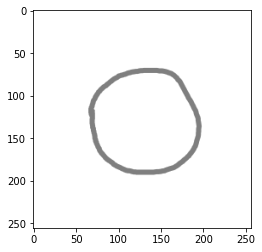

In [43]:
import cv2
import matplotlib.pyplot as plt

def show_edge(e):
  e = e.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  e = e[...,0,:]
  e = ((e+1.0)*127.5).clip(0,255).astype(np.uint8)
  plt.imshow(e, cmap = "gray", vmin=0, vmax=255)
  plt.show()
  # print(e)
  # display(e)

show_edge(edge)

In [44]:
c_code, c_indices = model.encode_to_c(edge)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[1]
edge_rec = model.cond_stage_model.decode(c_code)
# show_edge(torch.softmax(edge_rec, dim=1))

c_code torch.Size([1, 256, 16, 16]) torch.float32
c_indices torch.Size([1, 256]) torch.int64


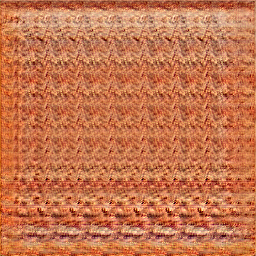

In [45]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

Time: 10.56954288482666 seconds
Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


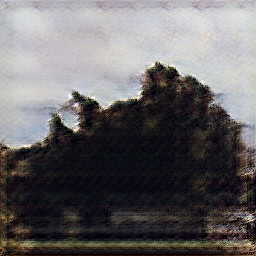

In [47]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      show_image(x_sample)